<img src="https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png" srcset="https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_130 130w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_260 260w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_390 390w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_520 520w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_650 650w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_780 780w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_910 910w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_1040 1040w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_1170 1170w, https://71022.cdn.cke-cs.com/RructTCFEHceQFc13ldy/images/6dbe93b28dbb43fbc9d50623b68a675a1fedd7608af93b46.png/w_1290 1290w" sizes="100vw" width="1290">
<p style='margin-top: 1rem; margin-bottom: 1rem;'>Developed by Marco Frodl, Principal Consultant for Generative AI @ <a href='https://go.mfr.one/tt-en' _target='blank'>Thinktecture AG</a> -- More about me on my <a href='https://go.mfr.one/marcofrodl-en' _target='blank'>profile page</a></p>

We want to implement a simple LangGraph AI workflow. The workflow should analyze the user's question and perform a web search on angular.dev if the question pertains to coding, and conduct an open web search for any other topic. To achieve this, you need to implement an AI-driven topic router as the first step in your AI workflow.

Tasks and details:

* All parts where you should implement something are marked with "..." or a sentence starting with "Task: "
* Include tracing with Langfuse if you have a key for it. If not, remove all references
* Use the Llama-3.1-70B LLM hosted on OVH
* You need a free API key for Tavily (tavily.com) stored as TAVILY_API_KEY in the Secrets Manager
* Use only the given nodes and conditional nodes; don't add new nodes
* Use the print_graph_result function to output the result of your graph execution
* We want answers to these two questions
  * Q1: Wie viele Komponenten brauche ich mindestens für das Setup von Routing?
  * Q2: Wie hoch ist der Berliner Fernsehturm?

If you need help:
* Use the LangChain chat bot for anything about LangChain: https://chat.langchain.com/
* For general questions you can use free https://huggingface.co/chat/ with nvidia/Llama-3.1-Nemotron-70B-Instruct-HF LLM - you need a free HuggingFace account to login

## Prettify Colab Notebook outputs

In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Set API keys via Colab Secrets

In [2]:
# import Colab Secrets userdata module
from google.colab import userdata
import os

# set Langfuse API keys
os.environ["LANGFUSE_PUBLIC_KEY"] = userdata.get('LANGFUSE_PUBLIC_KEY')
os.environ["LANGFUSE_SECRET_KEY"] = userdata.get('LANGFUSE_SECRET_KEY')

## Load libraries

In [ ]:
!pip -q install protobuf==3.20.3 langchain==0.3.8 langchain-core==0.3.21 langchain-community==0.3.8 langchain-openai==0.2.9
!pip -q install langgraph==0.2.53
!pip -q install langfuse==2.54.1
!pip -q install tavily-python

In [ ]:
# let's check the imported versions of the most important libraries
!pip show langchain
!pip show langchain-core
!pip show langchain_openai
!pip show langchain_community
!pip show langgraph
!pip show langfuse

## Prepare LLM

In [35]:
# for this notebook we use the free OVH AI endpoints and get access to a bunch of different open source LLMs
# you must register for an account to get your own (free) access token
from langchain_openai import ChatOpenAI

TEMPERATURE = 0
MAX_TOKENS = 1500

# OVH AI Endpoints Overview: https://endpoints.ai.cloud.ovh.net/

# OVH Mistral Nemo
#MODEL_NAME = "Mistral-Nemo-Instruct-2407"
#BASE_URL = "https://mistral-nemo-instruct-2407.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

# OVH Mistral-7B-0.2
#MODEL_NAME = "Mistral-7B-Instruct-v0.2"
#BASE_URL = "https://mistral-7b-instruct-v02.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

# OVH Mixtral 8x22B
#MODEL_NAME = "Mixtral-8x22B-Instruct-v0.1"
#BASE_URL = "https://mixtral-8x22b-instruct-v01.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

# OVH Llama3-70B
#MODEL_NAME = "Meta-Llama-3-70B-Instruct"
#BASE_URL = "https://llama-3-70b-instruct.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

# OVH Llama3-8B
#MODEL_NAME = "Meta-Llama-3-8B-Instruct"
#BASE_URL = "https://llama-3-8b-instruct.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

# OVH Llama3.1-70B
#MODEL_NAME = "Meta-Llama-3_1-70B-Instruct"
#BASE_URL = "https://llama-3-1-70b-instruct.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

# OVH Mamba Codestral 7B
#MODEL_NAME = "mamba-codestral-7B-v0.1"
#BASE_URL = "https://mamba-codestral-7b-v0-1.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1/"

# OVH CodeLlama-13B
#MODEL_NAME = "CodeLlama-13b-Instruct-hf"
#BASE_URL = "https://codellama-13b-instruct-hf.endpoints.kepler.ai.cloud.ovh.net/api/openai_compat/v1"

#Task: Implement the 4 necessary parameters here to successfully initialize the LLM.
llm = ChatOpenAI(..., api_key=userdata.get('OVH_AI_ENDPOINTS_ACCESS_TOKEN'))

## Prepare LangFuse

In [6]:
# prepare Langfuse as debugging and tracing framework for our Generative AI application - never develop GenAI apps without that!
from langfuse.callback import CallbackHandler
handler = ...

## Prepare prompts and instructions

### Prompt for final answer generation

In [7]:
# Define prompt for answer generation
prompt_template = """You are an assistant for question-answering tasks at ACME GmbH.
Think carefully about the context.
Just say 'Diese Frage kann ich nicht beantworten' if there is not enough or no context given.
Provide an answer to the user question using only the given context.
Use three sentences maximum and keep the answer concise.
Here is the context to use to answer the question:

{context}

Now, review the user question:

{question}

Write the answer in German. Don't output an English translation.

Answer:"""

### Prompt for topic routing at workflow start

In [21]:
# Task: we want to use few shot prompting here - fill the 2 gaps in the prompt template
# define prompt for routing
import json
from langchain_core.messages import HumanMessage, SystemMessage

router_instructions = """You are an expert at routing a user question to a devsearch or websearch.
The devsearch contains documents related to coding, programming, development practices, single page applications, the Angular framework.
If the question is related to coding or development but not specifically covered by the devsearch, still return 'devsearch'.
Use 'websearch' for non-coding questions.
Return JSON with a single key, "datasource," that is 'websearch' or 'devsearch' depending on the question.
Output JSON only, without any introduction or explanation.

Example output 1:
{
  "datasource": "..."
}

Example output 2:
{
  "datasource": "..."
}
"""

### Setup Tavily search client

In [9]:
# Tavily playground: https://app.tavily.com/playground
# Instantiating your TavilyClient
from tavily import TavilyClient
search_client = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))

In [ ]:
# Task: Test open web search with the question 'Wie hoch ist der Berliner Fernsehturm?' - we want to get back the best 2 results
# check https://docs.tavily.com/docs/python-sdk/tavily-search/api-reference#methods for the details
from langchain.schema import Document
results = search_client.search("...", search_depth="advanced", ...)

# List to store the generated Document objects
documents = []

# Iterate over each entry in the feed
for entry in results["results"]:
    # Extract the page content
    page_content = entry.get('content', 'No content')

    # Extract metadata
    metadata = {
        "title": entry.get('title', 'No Title'),
        "link": entry.get('url', 'No Link'),
        "score": entry.get('score', '0'),
    }

    # Create a Document object for this entry
    document = Document(page_content=page_content, metadata=metadata)

    # Append the document to the list
    documents.append(document)

# Output results
for doc in documents:
    # Extract metadata and page content
    title = doc.metadata.get('title', 'N/A')
    link = doc.metadata.get('link', 'N/A')
    score = doc.metadata.get('score', 'N/A')
    content = doc.page_content[:350]  # Limit content for readability

    # Print in a readable format
    print(f"Title: {title}")
    print(f"Link: {link}")
    print(f"Score: {score}")
    print(f"Content: {content}")
    print("-" * 50 )


In [ ]:
# Task: we want to limit the angular search to documents from angular.dev domain - include only this domain in the search
# check https://docs.tavily.com/docs/python-sdk/tavily-search/api-reference#methods for the details
# also have a look at https://docs.tavily.com/docs/python-sdk/tavily-search/api-reference#keyword-arguments-optional to understand what type of input Tavily expects for domains

from langchain.schema import Document
results = search_client.search("Wie viele Komponenten brauche ich mindestens für das Setup von Routing?", search_depth="advanced", max_results=2, ... , include_raw_content=True)

# List to store the generated Document objects
documents = []

# Iterate over each entry in the feed
for entry in results["results"]:
    # Extract the page content
    page_content = entry.get('raw_content', 'No content')

    # Extract metadata
    metadata = {
        "title": entry.get('title', 'No Title'),
        "link": entry.get('url', 'No Link'),
        "score": entry.get('score', '0'),
    }

    # Create a Document object for this entry
    document = Document(page_content=page_content, metadata=metadata)

    # Append the document to the list
    documents.append(document)

# Output results
for doc in documents:
    # Extract metadata and page content
    title = doc.metadata.get('title', 'N/A')
    link = doc.metadata.get('link', 'N/A')
    score = doc.metadata.get('score', 'N/A')
    content = doc.page_content[:80]  # Limit content for readability

    # Print in a readable format
    print(f"Title: {title}")
    print(f"Link: {link}")
    print(f"Score: {score}")
    print(f"Content: {content}")
    print("-" * 50 )

## Setup Graph

In [11]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    documents : List[str] # List of retrieved documents

In [14]:
from langchain_core.messages import HumanMessage
from langgraph.graph import START, END

### Helper function
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Nodes
def web_search_angular(state):
    """
    Run web search for Angular content on angular.dev

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("--- WEB SEARCH ANGULAR ---")
    question = state["question"]
    # Instantiating your TavilyClient
    from tavily import TavilyClient
    search_client = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))

    # Run open web search
    from langchain.schema import Document
    # Task: copy all the needed parts from your angular.dev test from above and insert them here
    results = search_client.search(question, ...)

    # List to store the generated Document objects
    documents = []

    # Iterate over each entry in the feed
    for entry in results["results"]:
        # Extract the page content: prefer raw_content, fall back to content, and use default if both are empty
        page_content = entry.get('raw_content') or entry.get('content') or "No content found"

        # Extract metadata
        metadata = {
            "title": entry.get('title', 'No Title'),
            "link": entry.get('url', 'No Link'),
            "score": entry.get('score', '0'),
        }

        # Create a Document object for this entry
        document = Document(page_content=page_content, metadata=metadata)

        # Append the document to the list
        documents.append(document)


    # Write retrieved documents to documents key in graph state
    print(f"> found {len(documents)} documents")
    return{"documents": documents}

def web_search_full(state):
    """
    Run web search for any content for given question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("--- WEB SEARCH FULL ---")
    question = state["question"]
    # Instantiating your TavilyClient
    from tavily import TavilyClient
    search_client = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))

    # Run open web search
    from langchain.schema import Document
    results = search_client.search(question, search_depth="advanced", max_results=2)

    # List to store the generated Document objects
    documents = []

    # Iterate over each entry in the feed
    for entry in results["results"]:
        # Extract the page content
        page_content = entry.get('content', 'No content')

        # Extract metadata
        metadata = {
            "title": entry.get('title', 'No Title'),
            "link": entry.get('url', 'No Link'),
            "score": entry.get('score', '0'),
        }

        # Create a Document object for this entry
        document = Document(page_content=page_content, metadata=metadata)

        # Append the document to the list
        documents.append(document)


    # Write retrieved documents to documents key in state
    print(f"> found {len(documents)} documents")
    return{"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = prompt_template.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation}

In [22]:
### Conditional nodes
def route_question(state):
    """
    Route question to web search full or websearch angular

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("--- TOPIC ROUTER ---")
    route_question = llm.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("> ROUTE QUESTION TO WEB_SEARCH_FULL ---")
        return "websearch"
    elif source == "devsearch":
        print("> ROUTE QUESTION TO WEB_SEARCH_ANGULAR ---")
        return "devsearch"

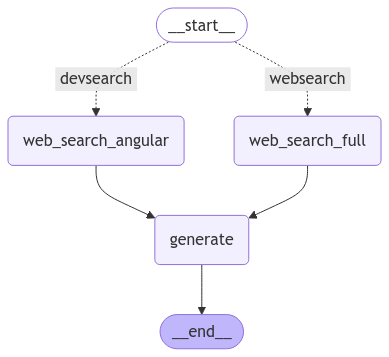

In [24]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search_full", web_search_full) # full websearch
workflow.add_node("web_search_angular", web_search_angular) # websearch angular.dev
workflow.add_node("generate", generate) # generate

# Define the edges
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "...", # Task: insert the correct node name here
        "devsearch": "...", # Task: insert the correct node name here
    },
)
workflow.add_edge("web_search_full", "...") # Task: insert the correct node name here
workflow.add_edge("web_search_angular", "...") # Task: insert the correct node name here
workflow.add_edge("generate", END)

# Compile
graph = workflow.compile()
# Task: Have a look at the given graph and display your graph setup - do you get the same result?
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# format result output
def print_graph_result(result):
    # Print question, generated answer, trust level, answer grade
    print("--- END OF AI-WORKFLOW ---\n")
    print(f"Question: {result.get('question', 'N/A')}")
    print(f"Answer: {result.get('generation').content if result.get('generation') else 'N/A'}")

    # Print additional metadata from the generation
    generation = result.get('generation')
    if generation:
        response_metadata = generation.response_metadata
        print("\nResponse Metadata:")
        for key, value in response_metadata.items():
            print(f"  {key}: {value}")
        print()

    # Print documents
    documents = result.get('documents', [])
    for index, doc in enumerate(documents):
        print(f"Document {index + 1}:")
        metadata = doc.metadata
        for key, value in metadata.items():
            print(f"  {key}: {value}")
        print(f"  Content: {doc.page_content[:80]}...")  # Limit content to 150 characters

In [ ]:
result = graph.invoke({"question": "Wie viele Komponenten brauche ich mindestens für das Setup von Routing?"}, config={"callbacks": [handler]})
print_graph_result(result)

In [ ]:
# Task: invoke the graph for the second question here (with Langfuse) and output the result
...